# GoProtect_стандартизация_названий

***Описание проекта:***

Компании-заказчику из разных источников поступают названия спортивных школ, написанные различным образом.

***Цели проекта:***

Необходимо разработать модель машинного обучения, которая позволит стандартизировать названия спортивных школ, т.е. будет сопоставлять произвольные варианты с эталоном и с учётом региона нахождения школы.

***Инструкция по выполнению проекта:***

1. Загрузка, подготовка и изучение данных
2. Создание обучающего датасета
3. Создание и  обучение модели
4. Выводы

***Описание исходных данных:***

Нам даны 2 датасета:
- Школы.csv; 
- Примерное написание.csv.

**Файл "Школы.csv"** является базовым датасетом, которые содержит следующие данные:
- school_id - идентификационный номер спортивной школы;
- name - название спортивной школы;
- region - регион нахождения спортивной школы.

**Файл "Примерное написание.csv"** представляет собой исходные произвольные варианты названий спортивных школ и состоит из 2 столбцов:
- school_id - идентификационный номер спортивной школы;
- name - название спортивной школы.

## 1. Загрузка, подготовка и изучение данных 

Сначала установим необходимые библиотеки:

In [5]:
!pip install -q scikit-learn --upgrade
!pip install -q imbalanced-learn --upgrade
!pip install -q sentence-transformers

Далее импортируем библиотеки, требующиеся для выполнения данного проекта:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import re

from sentence_transformers import (
    SentenceTransformer,
    InputExample,
    util,
    losses
)

from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

C:\Users\Dmitry\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Считываем CSV-файлы с данными с помощью библиотеки pandas и их в датафреймы:

In [9]:
basic_spell = pd.read_csv('Школы.csv')
approx_spell = pd.read_csv('Примерное написание.csv')

Выведем общую информацию полученных датафреймов с помощью функции `main_info`:

In [11]:
def main_info (data):
    print(f'Общая информация:')
    print(data.info(verbose=True))
    print()
    print(f'Первые пять строк таблицы:')
    display(data.head())
    print()
    print(f'Последние пять строк таблицы:')
    display(data.tail())
    print()
    print(f'Процент пропущенных значений в каждом столбце:')
    print((data.isna().sum()/len(data)*100).sort_values(ascending=False).head(25))
    print()
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')

In [12]:
main_info(basic_spell)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   school_id  306 non-null    int64 
 1   name       306 non-null    object
 2   region     306 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.3+ KB
None

Первые пять строк таблицы:


,school_id,name,region
0,1,Авангард,Московская область
1,2,Авангард,Ямало-Ненецкий АО
2,3,Авиатор,Республика Татарстан
3,4,Аврора,Санкт-Петербург
4,5,Ice Dream / Айс Дрим,Санкт-Петербург



Последние пять строк таблицы:


,school_id,name,region
301,305,Прогресс,Алтайский край
302,609,"""СШ ""Гвоздика""",Удмуртская республика
303,610,"СШОР ""Надежда Губернии",Саратовская область
304,611,КФК «Айсберг»,Пермский край
305,1836,"ООО ""Триумф""",Москва



Процент пропущенных значений в каждом столбце:
school_id    0.0
name         0.0
region       0.0
dtype: float64

Количество явных дубликатов: 0


В эталонных данных 306 строк и 3 столбца. Типы данных соответствуют содержимому, пропущенныхз значений нет, явные дубликаты отсутствуют.

Посмотрим, названия каких школ встречаются чаще всего:

In [14]:
basic_spell['name'].value_counts().head(10)

name
Олимп       5
Юность      4
СШОР № 1    3
СШОР № 4    3
Айсберг     3
СШОР №1     3
СШОР № 2    3
ДЮСШ № 2    2
Каскад      2
Керриган    2
Name: count, dtype: int64

Видно, что есть школы с одинаковым названием, причём некоторые школы неявно дублируются.

Посмотрим, школы каких регионов в основном представлены в данных:

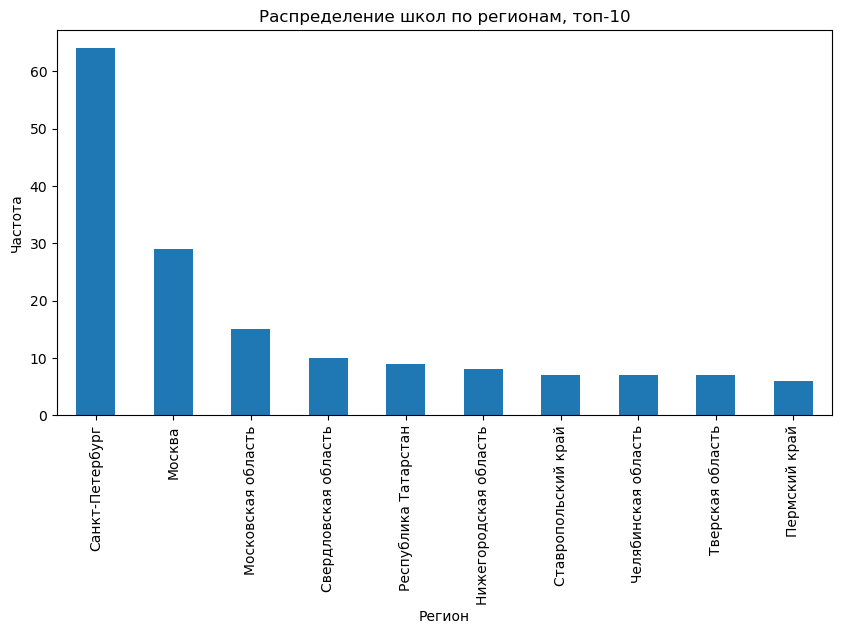

In [16]:
plt.figure(figsize=(10, 5))

basic_spell['region'].value_counts().head(10).plot(kind='bar');
plt.title('Распределение школ по регионам, топ-10')
plt.xlabel('Регион')
plt.ylabel('Частота')
plt.show();

Видно, что большая часть спортивных школ (около 65) - из Санкт-Петербурга, около 30 школ из Москвы, а остальные - из других регионов РФ. 

Проанализируем таблицу с примерными названиями школ:

In [18]:
main_info(approx_spell)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   school_id  895 non-null    int64 
 1   name       895 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.1+ KB
None

Первые пять строк таблицы:


,school_id,name
0,1836,"ООО ""Триумф"""
1,1836,"Москва, СК ""Триумф"""
2,610,"СШОР ""Надежда Губернии"
3,610,"Саратовская область, ГБУСО ""СШОР ""Надежда Губе..."
4,609,"""СШ ""Гвоздика"""



Последние пять строк таблицы:


,school_id,name
890,3,"Республика Татарстан, СШОР ФСО Авиатор"
891,3,"СШОР ФСО Авиатор, Республика Татарстан"
892,3,"Республика Татарстан, МБУ ДО СШОР «ФСО ""Авиатор""»"
893,2,"ЯНАО, СШ ""Авангард"""
894,1,"Московская область, СШ ""Авангард"""



Процент пропущенных значений в каждом столбце:
school_id    0.0
name         0.0
dtype: float64

Количество явных дубликатов: 0


В этих данных имеется 895 строк и 2 столбца. Типы данных соответствуют содержимому, пропущенные значения отсутствуют, явных дубликатов нет.

Посмотрим, есть ли повторяющиеся по названию школы:

In [20]:
approx_spell['name'].value_counts()

name
КФК "Динамо-Санкт-Петербург"                       2
ООО "Триумф"                                       1
Свердловская область, МБУ СШ No 8 Локомотив        1
Мастер                                             1
ШСФК Маска                                         1
                                                  ..
Санкт-Петрбург, СШОР Колпинского района            1
ГБУ ДО СШОР Колпинского района СПб                 1
СПб ГБУ СШОР Колпинского района                    1
МО г. Колпино, ГБУ ДО СШОР Колпинского р-на СПб    1
Московская область, СШ "Авангард"                  1
Name: count, Length: 894, dtype: int64

Все школы, кроме одной, имеют уникальные названия.

Посмотрим, много ли дубликатов школ по school_id:

In [22]:
approx_spell['school_id'].value_counts()

school_id
62     19
198    17
244    16
92     14
212    14
       ..
214     1
210     1
207     1
202     1
1       1
Name: count, Length: 264, dtype: int64

В данных есть такие school_id, которые часто повторяются.

## 2. Создание обучающего датасета

Удалим из названий эталонных школ все нежелательные символы:

In [26]:
basic_spell['name'] = basic_spell['name'].replace(r'[^0-9А-Яа-яёЁ\s]', ' ', regex=True)
basic_spell['name'].head()

0                Авангард
1                Авангард
2                 Авиатор
3                  Аврора
4                Айс Дрим
Name: name, dtype: object

Проведём аугментацию эталонного датасета. для этого создадим функцию copy_aug, которая будет создавать заданное количество копий ячейки, перемешивать элементы ячейки и произвольно менять буквы в каждом элементе: 

In [28]:
def copy_aug(text, num_copies):
    copies = []
    words = text.split()

    for i in range(num_copies):
        new_words = words.copy()
        
        if len(new_words) > 1:
            random.shuffle(new_words)  # Меняем местами слова
            
            for j in range(random.randint(3, 6)):  # Вносим случайные ошибки
                index = random.randint(0, len(new_words) - 1)
                new_words[index] = new_words[index][:index] + random.choice(new_words[index]) + new_words[index][index+1:]
            
            copies.append(' '.join(new_words))
        
        if len(new_words) == 1:
            for j in range(random.randint(1, 5)):  # Вносим случайные ошибки
                index = 0  # Устанавливаем индекс для слова с индексом 0
                new_char = chr(random.randint(1040, 1103))  # Генерируем случайную букву в нижнем регистре
                new_words[index] = new_words[index][:index] + new_char + new_words[index][index+1:]
            
            copies.append(' '.join(new_words))
    
    return copies

Передадим значение функции copy_aug на данных эталонных названий в список augmented:

In [30]:
augmented = []
for i in range(len(basic_spell)):
    augmented.append(copy_aug(basic_spell['name'][i], 10))
augmented

[['цвангард',
  'Ивангард',
  'Ъвангард',
  'Щвангард',
  'эвангард',
  'овангард',
  'Рвангард',
  'гвангард',
  'Евангард',
  'явангард'],
 ['Увангард',
  'пвангард',
  'явангард',
  'Цвангард',
  'щвангард',
  'явангард',
  'пвангард',
  'твангард',
  'Ьвангард',
  'Йвангард'],
 ['Свиатор',
  'Эвиатор',
  'Эвиатор',
  'чвиатор',
  'явиатор',
  'хвиатор',
  'Ъвиатор',
  'ывиатор',
  'Чвиатор',
  'Гвиатор'],
 ['оврора',
  'Пврора',
  'Чврора',
  'Зврора',
  'дврора',
  'мврора',
  'йврора',
  'сврора',
  'ыврора',
  'тврора'],
 ['ййс Дмим',
  'ирим ААс',
  'ирим Асс',
  'Дрим ААс',
  'сйс Дмим',
  'ррим ААс',
  'Айс ДДим',
  'мрим ААс',
  'ййс ДДим',
  'сйс Дрим'],
 ['кйсберг',
  'пйсберг',
  'хйсберг',
  'Жйсберг',
  'вйсберг',
  'Вйсберг',
  'вйсберг',
  'Дйсберг',
  'айсберг',
  'ъйсберг'],
 ['ьйсберг',
  'лйсберг',
  'бйсберг',
  'цйсберг',
  'зйсберг',
  'Фйсберг',
  'айсберг',
  'цйсберг',
  'Вйсберг',
  'Лйсберг'],
 ['Ейсберг',
  'хйсберг',
  'Мйсберг',
  'уйсберг',
  'ийсберг'

Создадим столбец 'augmented' в эталонных данных, передав ему данные из списка augmented. Разобьём аугментированные данные:

In [32]:
basic_spell['augmented'] = augmented
basic_spell = basic_spell.explode('augmented').reset_index(drop=True)

Объединим регион и названия школ в эталонных данных:

In [34]:
basic_spell['name'] = basic_spell[['region', 'name']].agg(' '.join, axis=1)
basic_spell['augmented'] = basic_spell[['region', 'augmented']].agg(lambda x: ' '.join(map(str, x)), axis=1)
basic_spell.head()

,school_id,name,region,augmented
0,1,Московская область Авангард,Московская область,Московская область цвангард
1,1,Московская область Авангард,Московская область,Московская область Ивангард
2,1,Московская область Авангард,Московская область,Московская область Ъвангард
3,1,Московская область Авангард,Московская область,Московская область Щвангард
4,1,Московская область Авангард,Московская область,Московская область эвангард


Удалим лишние столбцы:

In [36]:
basic_spell_aug = basic_spell.drop(['school_id','region'], axis=1)
basic_spell_aug.head()

,name,augmented
0,Московская область Авангард,Московская область цвангард
1,Московская область Авангард,Московская область Ивангард
2,Московская область Авангард,Московская область Ъвангард
3,Московская область Авангард,Московская область Щвангард
4,Московская область Авангард,Московская область эвангард


Аналогично удалим из таблицы с примерными названиями все лишние символы:

In [38]:
approx_spell['name'] = approx_spell['name'].replace(r'[^0-9А-Яа-яёЁ\s]', ' ', regex=True)
approx_spell['name']

0                                           ООО  Триумф 
1                                    Москва  СК  Триумф 
2                                 СШОР  Надежда Губернии
3      Саратовская область  ГБУСО  СШОР  Надежда Губе...
4                                          СШ  Гвоздика 
                             ...                        
890               Республика Татарстан  СШОР ФСО Авиатор
891               СШОР ФСО Авиатор  Республика Татарстан
892    Республика Татарстан  МБУ ДО СШОР  ФСО  Авиатор  
893                                  ЯНАО  СШ  Авангард 
894                    Московская область  СШ  Авангард 
Name: name, Length: 895, dtype: object

## 3. Создание, обучение и тестирование модели (baseline)

Разобьём эталонные данные на тренировочные и тестовые выборки:

In [41]:
train, test = train_test_split(basic_spell_aug, test_size=0.2, random_state=7)

In [42]:
print(train.shape)
print(test.shape)

(2440, 2)
(611, 2)


In [43]:
train.head()

,name,augmented
2574,Санкт-Петербург Чемпион,Санкт-Петербург фемпион
2946,Республика Коми РФСОО ФФККРК,Республика Коми КФККРК РОСОО
1579,Краснодарский край Снеговик,Краснодарский край Снеговик
341,Ленинградская область ВСШОР,Ленинградская область ТСШОР
147,Москва Ангелы Плющенко,Москва ынгелы Поющенко


In [44]:
test.head()

,name,augmented
1366,Ростовская область Профессионал,Ростовская область Брофессионал
280,Санкт-Петербург Вершина,Санкт-Петербург Лершина
514,Санкт-Петербург ДЮСШ СК Юбилейный,Санкт-Петербург ДЮСШ ЮЮилейный СКК
1165,Тульская область ОКСШОР,Тульская область УКСШОР
619,Санкт-Петербург Звездный лед,Санкт-Петербург дед Знездный


Вызовем модель Sentence Transformer:

In [46]:
model = SentenceTransformer('sentence-transformers/LaBSE')

Проверим её на эталонных данных, создав corpus и query:

In [48]:
bs_corpus = model.encode(basic_spell.name.values)

In [49]:
bs_query = model.encode(test.augmented.values)
bs_query

array([[ 0.04123154, -0.01427394, -0.03766761, ..., -0.05315909,
         0.03807849, -0.06917227],
       [ 0.00369755, -0.01541427,  0.0686354 , ..., -0.03048255,
         0.07017568, -0.00952969],
       [ 0.00603099, -0.04872202,  0.02724311, ..., -0.03367499,
         0.05610256,  0.01494768],
       ...,
       [ 0.02564431, -0.05165027,  0.01749036, ...,  0.00446939,
         0.07582951,  0.07222291],
       [ 0.06037916, -0.05493629,  0.00324913, ..., -0.0028933 ,
        -0.01081937, -0.00116317],
       [ 0.05545827,  0.01601637,  0.06509603, ..., -0.03290213,
         0.0112794 , -0.05717558]], dtype=float32)

Применим semantic_search:

In [51]:
bs_search_result = util.semantic_search(bs_query, bs_corpus, top_k=5)
bs_search_result

[[{'corpus_id': 1360, 'score': 0.8776785135269165},
  {'corpus_id': 1361, 'score': 0.8776785135269165},
  {'corpus_id': 1363, 'score': 0.8776785135269165},
  {'corpus_id': 1364, 'score': 0.8776785135269165},
  {'corpus_id': 1362, 'score': 0.8776785135269165}],
 [{'corpus_id': 260, 'score': 0.8813669681549072},
  {'corpus_id': 261, 'score': 0.8813669681549072},
  {'corpus_id': 263, 'score': 0.8813669681549072},
  {'corpus_id': 264, 'score': 0.8813669681549072},
  {'corpus_id': 262, 'score': 0.8813669681549072}],
 [{'corpus_id': 510, 'score': 0.8868335485458374},
  {'corpus_id': 511, 'score': 0.8868335485458374},
  {'corpus_id': 513, 'score': 0.8868335485458374},
  {'corpus_id': 514, 'score': 0.8868335485458374},
  {'corpus_id': 512, 'score': 0.8868335485458374}],
 [{'corpus_id': 1160, 'score': 0.98122239112854},
  {'corpus_id': 1161, 'score': 0.98122239112854},
  {'corpus_id': 1163, 'score': 0.98122239112854},
  {'corpus_id': 1164, 'score': 0.98122239112854},
  {'corpus_id': 1162, 'scor

Добавим в тестовую выборку данные о порядковом номере и названии подходящих вариантов, а также булевы значения, соответствует ли предсказание действительности из топ-1 и топ-5:

In [53]:
test['candidate_idx_5'] = [[x['corpus_id'] for x in row] for row in bs_search_result]

In [54]:
test['candidate_names'] = test.candidate_idx_5.transform(lambda x:basic_spell.name.values[x])

In [55]:
test['top_1'] = test.apply(lambda x: x['name'] == x['candidate_names'][0], axis=1)

In [56]:
test['top_5'] = test.apply(lambda x: x['name'] in x['candidate_names'], axis=1)

In [57]:
test.head()

,name,augmented,candidate_idx_5,candidate_names,top_1,top_5
1366,Ростовская область Профессионал,Ростовская область Брофессионал,"[1360, 1361, 1363, 1364, 1362]","[Ростовская область Профессионал, Ростовская о...",True,True
280,Санкт-Петербург Вершина,Санкт-Петербург Лершина,"[260, 261, 263, 264, 262]","[Санкт-Петербург Буревестник, Санкт-Петербург ...",False,False
514,Санкт-Петербург ДЮСШ СК Юбилейный,Санкт-Петербург ДЮСШ ЮЮилейный СКК,"[510, 511, 513, 514, 512]","[Санкт-Петербург ДЮСШ СК Юбилейный, Санкт-Пете...",True,True
1165,Тульская область ОКСШОР,Тульская область УКСШОР,"[1160, 1161, 1163, 1164, 1162]","[Тульская область ОКСШОР, Тульская область ОКС...",True,True
619,Санкт-Петербург Звездный лед,Санкт-Петербург дед Знездный,"[370, 371, 373, 374, 372]","[Санкт-Петербург Голден айс, Санкт-Петербург Г...",False,False


Посмотрим, насколько отличается точность на эталонных данных в зависимости от размера топа:

In [59]:
(test.top_1.sum()/test.shape[0])

0.8477905073649754

In [60]:
(test.top_5.sum()/test.shape[0])

0.8494271685761048

Примерно в 85 % случаев модель правильно соотносит аугментированные данные и эталон.

Проверим, как покажет себя модель на данных с примерными названиями:

In [62]:
as_corpus = model.encode(basic_spell.name.values)

In [63]:
as_query = model.encode(approx_spell.name.values)
as_query

array([[-0.00207801, -0.0239523 , -0.02229751, ..., -0.04380861,
        -0.04946658,  0.01870136],
       [ 0.00010735, -0.03549797, -0.02038508, ..., -0.07642706,
        -0.0164324 , -0.00842058],
       [-0.04339316, -0.00606125,  0.01834403, ..., -0.05802705,
         0.03009207, -0.03719969],
       ...,
       [ 0.01674769, -0.05944565,  0.00251855, ...,  0.03913211,
         0.06869863,  0.07293065],
       [-0.07099183, -0.00354019,  0.00079976, ..., -0.0271966 ,
        -0.06254366, -0.0503183 ],
       [-0.01921774,  0.00944569,  0.01737064, ..., -0.05126878,
        -0.01104421, -0.04745039]], dtype=float32)

In [64]:
as_search_result = util.semantic_search(as_query, as_corpus, top_k=1)
as_search_result

[[{'corpus_id': 3041, 'score': 0.7880867123603821}],
 [{'corpus_id': 3041, 'score': 0.8680867552757263}],
 [{'corpus_id': 3022, 'score': 0.7115955352783203}],
 [{'corpus_id': 3022, 'score': 0.972446858882904}],
 [{'corpus_id': 3011, 'score': 0.6330892443656921}],
 [{'corpus_id': 1920, 'score': 0.5757722854614258}],
 [{'corpus_id': 2991, 'score': 1.0000001192092896}],
 [{'corpus_id': 2991, 'score': 0.8255811929702759}],
 [{'corpus_id': 2981, 'score': 0.7651783227920532}],
 [{'corpus_id': 2981, 'score': 0.9813424944877625}],
 [{'corpus_id': 2100, 'score': 0.7312199473381042}],
 [{'corpus_id': 2961, 'score': 0.8017969727516174}],
 [{'corpus_id': 2951, 'score': 0.9619972705841064}],
 [{'corpus_id': 2951, 'score': 0.8633503317832947}],
 [{'corpus_id': 2947, 'score': 0.7015315294265747}],
 [{'corpus_id': 2931, 'score': 0.4817323684692383}],
 [{'corpus_id': 2931, 'score': 0.8894945383071899}],
 [{'corpus_id': 2921, 'score': 0.5045230984687805}],
 [{'corpus_id': 2911, 'score': 0.74265074729919

Передадим в таблицу с примерными названиями оценку предсказания, название предсказанной школы и её id:

In [66]:
approx_spell['score'] = [[x['score'] for x in row] for row in as_search_result]

In [67]:
approx_spell['corpus_id'] = [[x['corpus_id'] for x in row] for row in as_search_result]

In [68]:
approx_spell['candidate_name'] = approx_spell.corpus_id.transform(lambda x:basic_spell.name.values[x])

In [69]:
approx_spell['school_id_pred'] = approx_spell.corpus_id.transform(lambda x:basic_spell.school_id.values[x])

In [70]:
approx_spell = approx_spell.drop('corpus_id', axis=1)

In [71]:
approx_spell.head(5)

,school_id,name,score,candidate_name,school_id_pred
0,1836,ООО Триумф,[0.7880867123603821],[Москва ООО Триумф ],[1836]
1,1836,Москва СК Триумф,[0.8680867552757263],[Москва ООО Триумф ],[1836]
2,610,СШОР Надежда Губернии,[0.7115955352783203],[Саратовская область СШОР Надежда Губернии],[610]
3,610,Саратовская область ГБУСО СШОР Надежда Губе...,[0.972446858882904],[Саратовская область СШОР Надежда Губернии],[610]
4,609,СШ Гвоздика,[0.6330892443656921],[Удмуртская республика СШ Гвоздика ],[609]


Вычислим средную точность предсказания:

In [73]:
(approx_spell['school_id'] == approx_spell['school_id_pred']).mean()

0.6905027932960894

## 4. Выводы

Таким образом, в первом приближении был проведён анализ полученных датасетов и проверена модель Sentence Transformer для соотнесения примерных названий школ и эталонов. 

Базовая модель показала результат точности - 0.69, т.е. почти в 70 % случаев модели удаётся правильно идентифицировать id спортивной школы. 

Для дальнейшего повышения точности предсказания необходимо тщательнее анализировать имеющиеся датасеты (в частности, на предмет неявных дубликатов, выбросов и т.д.), а также изменять параметры базовой модели и исопльзовать иные модели машинного обучения.

In [120]:
!pip install -q session_info
import session_info
session_info.show()